In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("boston.csv")

判断因变量需要进行ln变换（lambda较为接近0）

0.2166209012915364


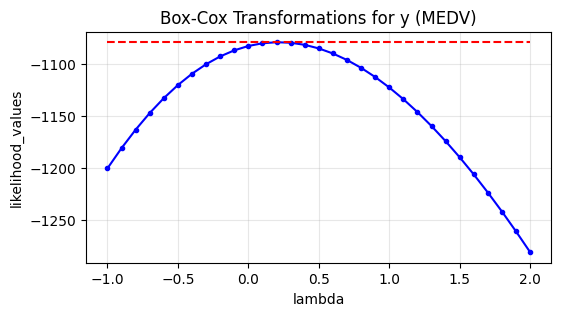

In [3]:
# Box-Cox Transformations for y (Median value of owner-occupied homes in $1000's)
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['MEDV'])
lamb = np.linspace(-1, 2, 31)

likelihood_values = [stats.boxcox_llf(i, df['MEDV']) for i in lamb]
fig = plt.figure(figsize=(6,3))
plt.plot(lamb, likelihood_values, 'b.-')
plt.hlines(max(likelihood_values), -1, 2, colors='red', linestyles='--')
plt.grid(alpha = 0.3)
plt.xlabel('lambda')
plt.ylabel('likelihood_values')
plt.title('Box-Cox Transformations for y (MEDV)')
# plt.vlines(lamb[likelihood_values.index(max(likelihood_values))], -28000, max(likelihood_values))
# plt.ylim(-26000, -10000)
print(fitted_lambda)

In [4]:
df['lnMEDV'] = np.log(df['MEDV'])

In [5]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'lnMEDV'],
      dtype='object')

数据分部情况概览

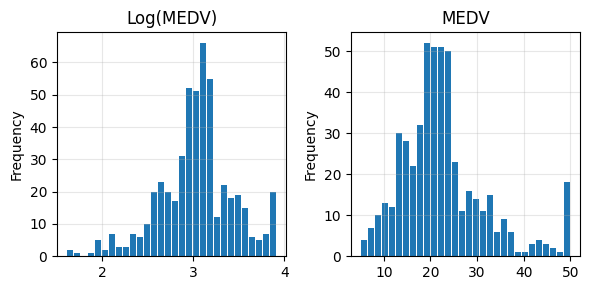

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
df['lnMEDV'].plot.hist(ax = axes[0], title = "Log(MEDV)", rwidth=0.8, bins=30)
axes[0].grid(alpha=0.3)
df['MEDV'].plot.hist(ax = axes[1], title = "MEDV", rwidth=0.8, bins=30)
axes[1].grid(alpha=0.3)
plt.tight_layout()

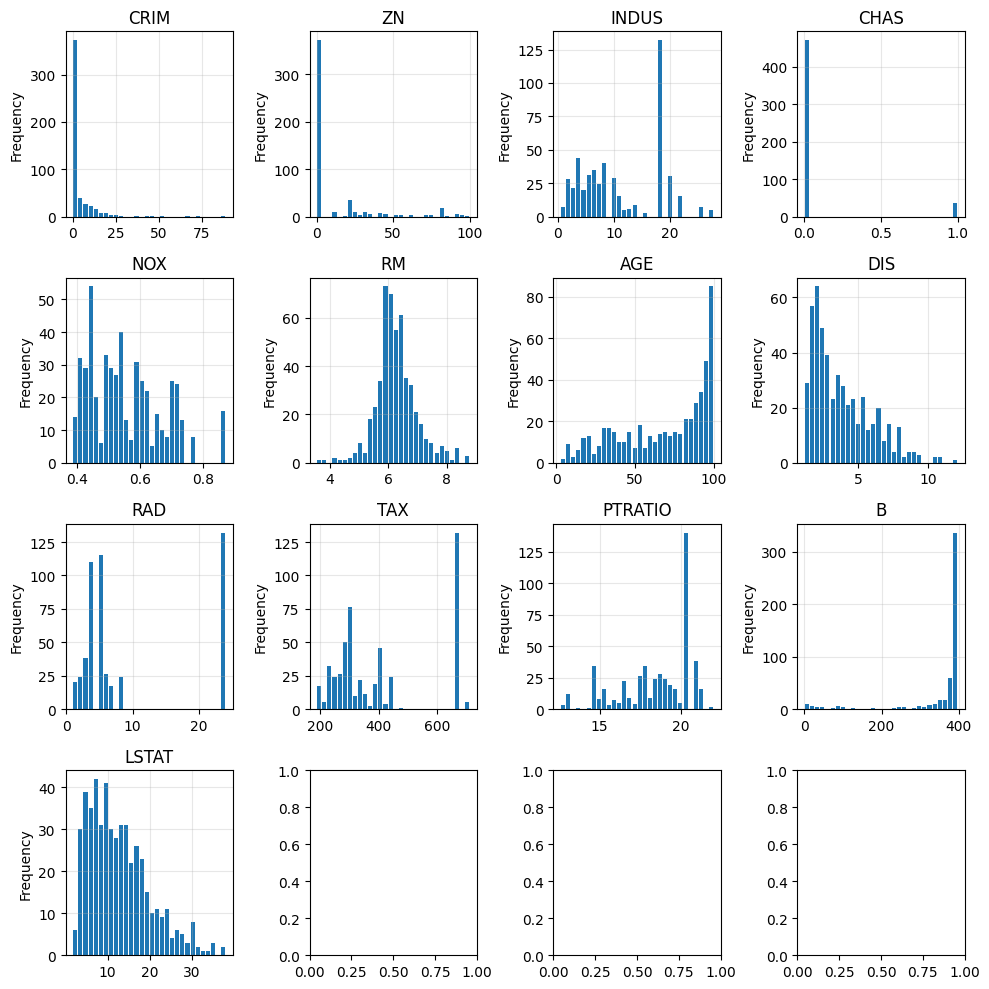

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(len(df.columns[:-2])):
    df[df.columns[i]].plot.hist(ax = axes[i//4][i%4], title = df.columns[i], rwidth=0.8, bins=30)
    axes[i//4][i%4].grid(alpha=0.3)
plt.tight_layout()

correlation matrix

<Axes: >

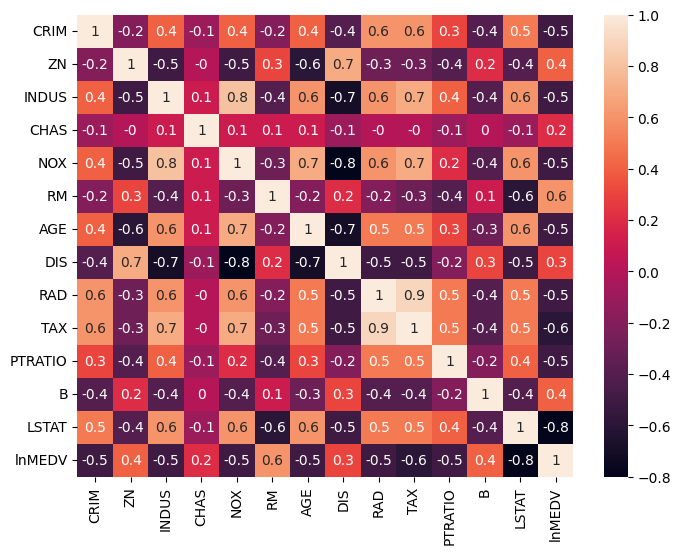

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(round(df[df.columns.drop('MEDV')].corr(),1), annot=True)

train、validation构造，最终需要用最佳模型对所有data进行回归

In [9]:
# Split training dataset and validation dataset
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(df.drop(['MEDV'], axis=1), test_size=0.5, random_state=1)

In [10]:
training_set = training_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)

In [11]:
# Data explore
# sns.pairplot(df)

In [12]:
from statsmodels.formula.api import ols ,wls
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.diagnostic as smd

In [13]:
# Run simple regression for every X
reg_result = []
reg_resid = {}
reg_fitval = {}
for i in training_set.columns.drop('lnMEDV'):
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    # beta
    beta = reg_model.params.iloc[1]
    # t-value
    tValue = reg_model.tvalues.iloc[1]
    # Durbin-Watson test statiitcs
    dwt = sms.durbin_watson(reg_model.resid)
    # Jarque-Bera test Chi^2 two-tail prob
    jbt = sms.jarque_bera(reg_model.resid)[1]
    # Breusch-Pagan Test p-value
    bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]
    reg_result.append([beta, abs(tValue), dwt, jbt, bpt])
    reg_fitval[i] = reg_model.fittedvalues
    reg_resid[i] = reg_model.resid

进行单变量回归，Drop掉t最小的variable：CHAS

In [14]:
pd.set_option('display.float_format', '{:.3f}'.format)
simple_reg_result = pd.DataFrame(reg_result, index=training_set.columns.drop('lnMEDV'), columns=['beta','abs(tValue)','Durbin-Watson test','Jarque-Bera test (pValue)','Breusch-Pagan (pValue)']).sort_values('abs(tValue)', ascending=False)

simple_reg_result

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.045,21.837,2.009,0.000,0.000
RM,0.391,13.200,1.975,0.000,0.017
CRIM,-0.026,11.447,1.985,0.002,0.000
INDUS,-0.036,11.315,1.852,0.000,0.000
TAX,-0.001,10.452,1.919,0.000,0.000
NOX,-1.852,9.969,1.784,0.000,0.000
AGE,-0.007,8.907,1.874,0.000,0.000
PTRATIO,-0.095,8.906,1.837,0.000,0.369
RAD,-0.022,8.410,1.854,0.001,0.000
DIS,0.079,7.088,1.799,0.001,0.000


单变量回归的residual分析

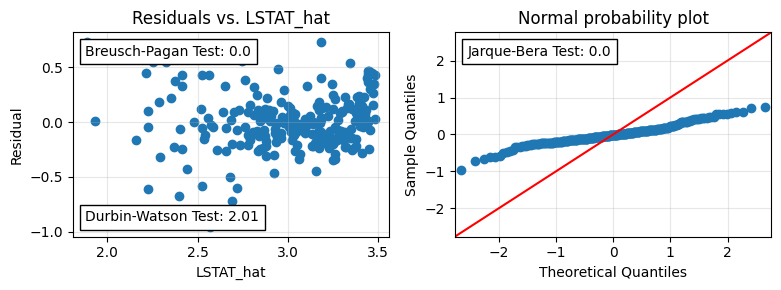

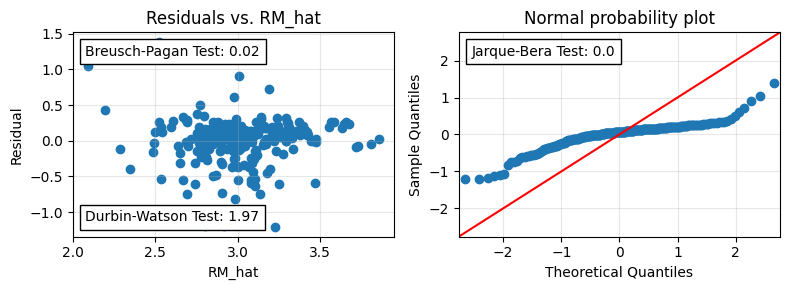

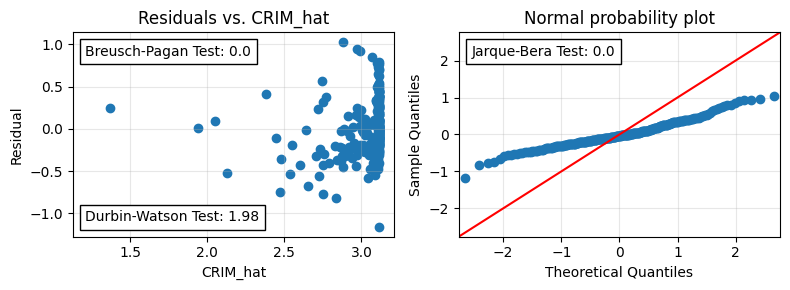

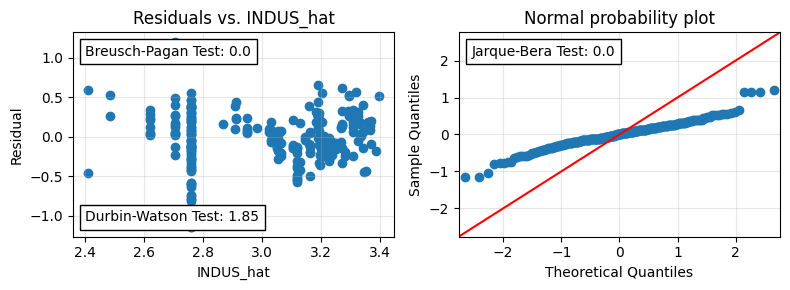

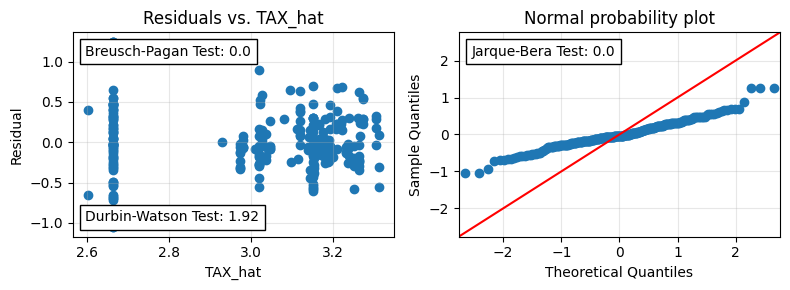

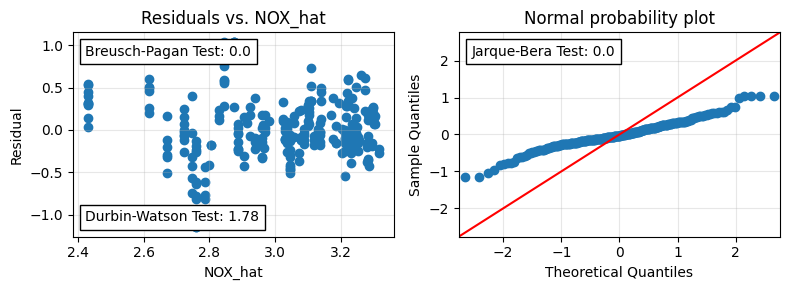

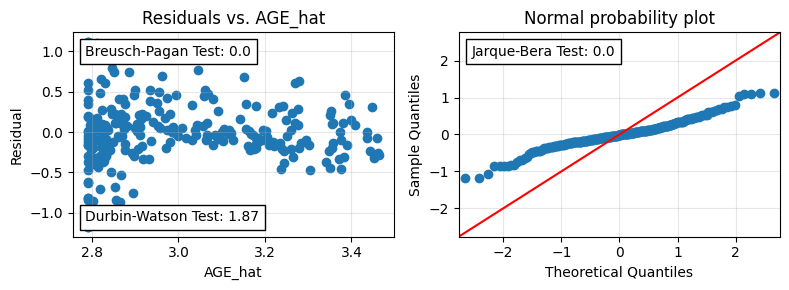

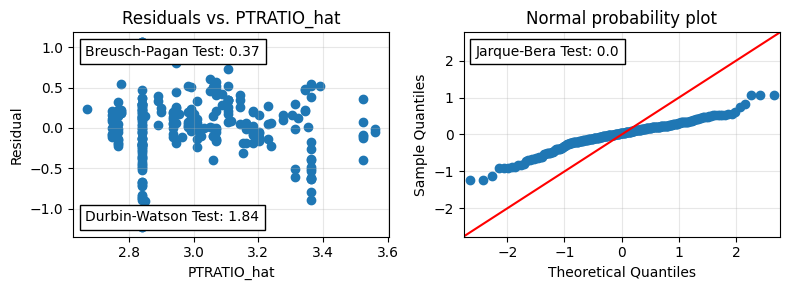

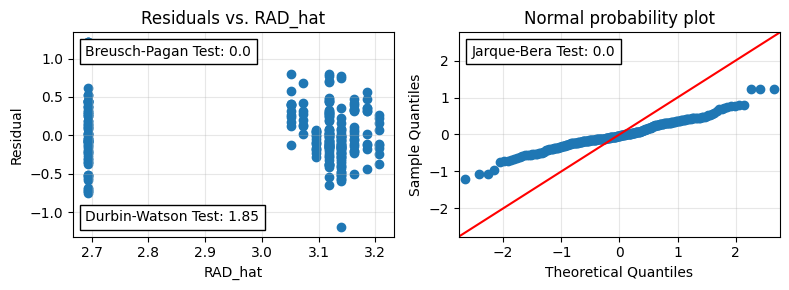

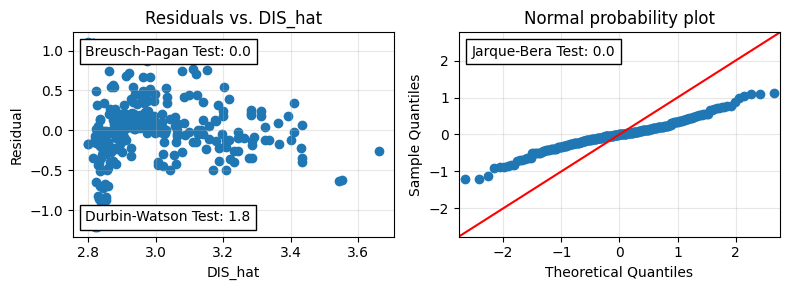

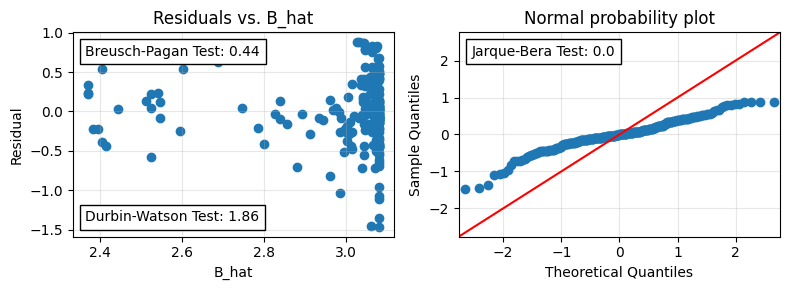

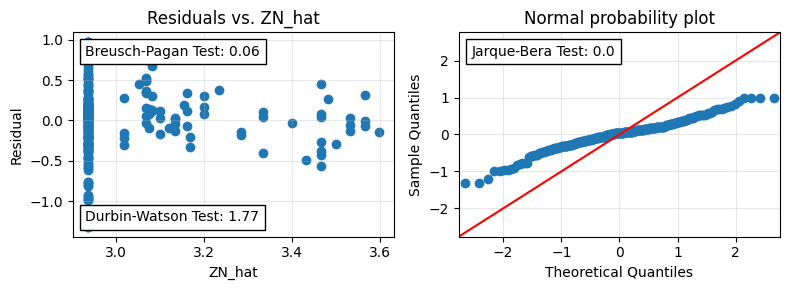

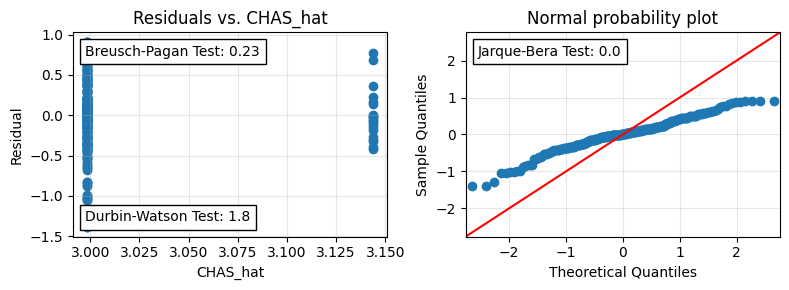

In [15]:
from matplotlib.offsetbox import AnchoredText
for i in simple_reg_result.index:
        fig, axs = plt.subplots(1, 2, figsize=(8,3))

        axs[0].scatter(reg_fitval[i], reg_resid[i])
        axs[0].grid(alpha = 0.3)
        axs[0].set_title('Residuals vs. '+i+'_hat')
        axs[0].set_ylabel('Residual')
        axs[0].set_xlabel(i+'_hat')
        anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(simple_reg_result.loc[i,'Breusch-Pagan (pValue)'],2)), loc=2)
        axs[0].add_artist(anchored_text)
        anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(simple_reg_result.loc[i,'Durbin-Watson test'],2)), loc=3)
        axs[0].add_artist(anchored_text)


        sm.qqplot(reg_resid[i], line="45", ax=axs[1])
        axs[1].grid(alpha = 0.3)
        axs[1].set_title('Normal probability plot')
        anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(simple_reg_result.loc[i,'Jarque-Bera test (pValue)'],2)), loc=2)
        axs[1].add_artist(anchored_text)
        fig.tight_layout()

Drop掉t最小的variable-CHAS之后，剩下的12个变量即为我们的variable pool

In [16]:
candidate = simple_reg_result[simple_reg_result['abs(tValue)']>2]
candidate

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.045,21.837,2.009,0.000,0.000
RM,0.391,13.200,1.975,0.000,0.017
CRIM,-0.026,11.447,1.985,0.002,0.000
INDUS,-0.036,11.315,1.852,0.000,0.000
TAX,-0.001,10.452,1.919,0.000,0.000
NOX,-1.852,9.969,1.784,0.000,0.000
AGE,-0.007,8.907,1.874,0.000,0.000
PTRATIO,-0.095,8.906,1.837,0.000,0.369
RAD,-0.022,8.410,1.854,0.001,0.000
DIS,0.079,7.088,1.799,0.001,0.000


全回归

In [17]:
total_candidate=candidate.index.to_list()
syntax_var=str(total_candidate).replace("[","").replace("]","").replace("'","").replace(","," +")
reg_model=ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
reg_model_validation = ols('lnMEDV ~ '+ syntax_var, data=validation_set).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     72.63
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           9.08e-73
Time:                        22:38:41   Log-Likelihood:                 54.499
No. Observations:                 253   AIC:                            -83.00
Df Residuals:                     240   BIC:                            -37.06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1887      0.306     13.703      0.0

In [18]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(reg_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(reg_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]

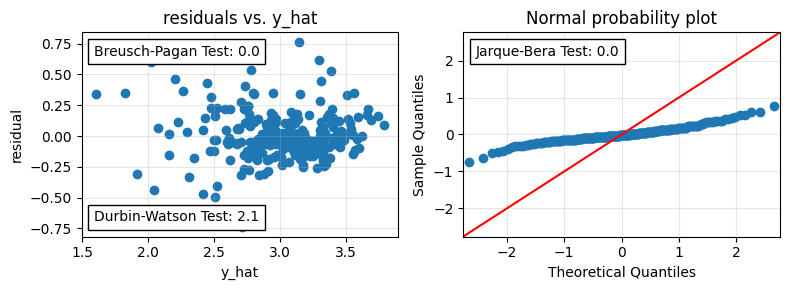

In [19]:
from matplotlib.offsetbox import AnchoredText
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues, reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)
anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(dwt,2)), loc=3)
axs[0].add_artist(anchored_text)

sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

Text(0.5, 1.0, 'Residual Distribution')

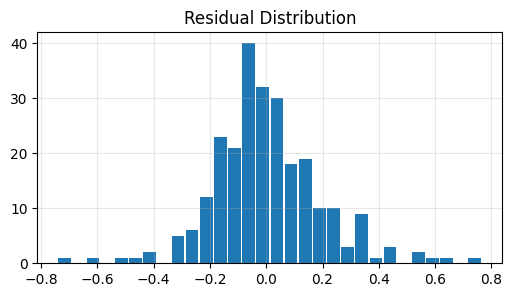

In [20]:
ax1 = reg_model.resid.hist(bins=30, figsize=(6,3), rwidth=0.9)
ax1.grid(alpha = 0.3)
ax1.set_title('Residual Distribution')

In [21]:
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

residual_data_valid = pd.concat([abs(reg_model_validation.resid),reg_model_validation.fittedvalues], axis=1)
residual_data_valid.columns = ['abs_residual', 'y_hat']
residual_model_valid = ols('abs_residual ~ y_hat', data=residual_data_valid).fit()

In [22]:
wls_whole_model = wls('lnMEDV ~ '+ syntax_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
wls_whole_model_valid = wls('lnMEDV ~ '+ syntax_var, data=validation_set, weights = 1/residual_model_valid.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.800
Model:                            WLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     79.95
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           1.09e-76
Time:                        22:38:44   Log-Likelihood:                 67.374
No. Observations:                 253   AIC:                            -108.7
Df Residuals:                     240   BIC:                            -62.81
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7895      0.291     13.025      0.0

以下是model selection环节

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
def press_criterion(reg_data, ind_variables, freq):
    press = 0
    for i in range(0, len(reg_data)-freq+1, freq):
        try:
            wls_model = wls('lnMEDV ~ '+ind_variables, data=reg_data.drop(range(i,i+freq)), weights = 1/residual_model.fittedvalues.drop(range(i,i+freq))).fit()
        except:
            return np.nan
        press += ((wls_model.predict(reg_data[ind_variables.split(' + ')].iloc[i:i+freq]).values[0] - reg_data['lnMEDV'][i:i+freq])**2).sum()
    return press

def mallows_cp(reg_data, muliple_variable_list, wls_whole_model, wls_model):
    c = wls_model.ssr/wls_whole_model.mse_resid-(len(reg_data)-2*(len(muliple_variable_list)+1)+1)
    return c
    
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

partial f test，每一轮的选择标准为p value不大于0.05

In [27]:
partial_f_test_treshold = 0.05

In [28]:
# stepwise regression processing
X_candidate = candidate.index[1:]
X_candidate_collection = [candidate.index[0]]

while len(X_candidate) > 0:
    add_list = {}
    for i in X_candidate:
        
        syntax_var = str(X_candidate_collection+[i]).replace("[","").replace("]","").replace("'","").replace(","," +")
        reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
        
        hypotheses = '('+i+' = 0)'
        partial_f_test = reg_model.f_test(hypotheses).pvalue
        add_list[i] = partial_f_test
        print("model contains: "+syntax_var)
    add_list = pd.Series(add_list).sort_values()
    print(add_list.iloc[[0]])
    if add_list.iloc[0] < partial_f_test_treshold:
        X_candidate_collection.append(add_list.index[0])
    else:
        break
    # check whether affect previous variables
    syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
    reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
    variables_pValue = reg_model.pvalues[1:]
    delete_var = variables_pValue.where(variables_pValue > partial_f_test_treshold).dropna().index.to_list()
    [X_candidate_collection.remove(delete) for delete in delete_var]

    X_candidate = X_candidate.drop(add_list.index[0])
    

model contains: LSTAT + RM
model contains: LSTAT + CRIM
model contains: LSTAT + INDUS
model contains: LSTAT + TAX
model contains: LSTAT + NOX
model contains: LSTAT + AGE
model contains: LSTAT + PTRATIO
model contains: LSTAT + RAD
model contains: LSTAT + DIS
model contains: LSTAT + B
model contains: LSTAT + ZN
CRIM   0.000
dtype: float64
model contains: LSTAT + CRIM + RM
model contains: LSTAT + CRIM + INDUS
model contains: LSTAT + CRIM + TAX
model contains: LSTAT + CRIM + NOX
model contains: LSTAT + CRIM + AGE
model contains: LSTAT + CRIM + PTRATIO
model contains: LSTAT + CRIM + RAD
model contains: LSTAT + CRIM + DIS
model contains: LSTAT + CRIM + B
model contains: LSTAT + CRIM + ZN
PTRATIO   0.000
dtype: float64
model contains: LSTAT + CRIM + PTRATIO + RM
model contains: LSTAT + CRIM + PTRATIO + INDUS
model contains: LSTAT + CRIM + PTRATIO + TAX
model contains: LSTAT + CRIM + PTRATIO + NOX
model contains: LSTAT + CRIM + PTRATIO + AGE
model contains: LSTAT + CRIM + PTRATIO + RAD
model c

最终选出的model为四变量：LSTAT + CRIM + PTRATIO + RM

以下是对4变量及其上下的3、5变量进行所有combination的test

In [29]:
from itertools import combinations

def combine(temp_list, n):
    temp_list2 = []
    for c in combinations(temp_list, n):
        temp_list2.append(c)
    return temp_list2

candidate_4=combine(total_candidate, 4)
candidate_3=combine(total_candidate, 3)
candidate_5=combine(total_candidate, 5)


In [30]:
# candidate_4
ind_var = str(candidate_4[0]).replace("'",'').replace("(",'').replace(")",'').replace(",",' +')
print(ind_var)

LSTAT + RM + CRIM + INDUS


In [31]:
def cal_table(candidate,wls_whole_model):
    criterions = []
    k = 0
    for i in candidate:
        ind_var = str(i).replace("'",'').replace("(",'').replace(")",'').replace(",",' +')
        
        reg_model = ols('lnMEDV ~ '+ind_var, data=training_set).fit()
        
        residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
        residual_data.columns = ['abs_residual', 'y_hat']
        residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()
        try:
            wls_model = wls('lnMEDV ~ '+ind_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
        except:
            p = len(i)
            sse = np.nan
            req = np.nan
            rsq_a = np.nan
            cp = np.nan
            aic = np.nan
            bic = np.nan
            press = np.nan

        
        p = len(i)
        sse = wls_model.ssr
        rsq = wls_model.rsquared
        rsq_a = wls_model.rsquared_adj
        cp = mallows_cp(training_set, i, wls_whole_model, wls_model)
        aic = wls_model.aic
        bic = wls_model.bic
        press = press_criterion(training_set, ind_var, 1)
        criterions.append([ind_var, p,sse,rsq,rsq_a,cp,aic,bic,press])
        k+=1
        print(k)
    return criterions

In [32]:
# criterions_4=cal_table(candidate_4,wls_whole_model)

In [33]:
# criterions_5=cal_table(candidate_5,wls_whole_model)
# criterions_3=cal_table(candidate_3,wls_whole_model)

In [34]:
# criterions_df_4 = pd.DataFrame(criterions_4, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')
# criterions_df_5 = pd.DataFrame(criterions_5, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')
# criterions_df_3 = pd.DataFrame(criterions_3, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')


In [35]:
# criterions_df = pd.concat([criterions_df_3, criterions_df_4, criterions_df_5])

In [36]:
criterions_df = pd.read_csv("criterions_df.csv", index_col=0)

以下是部分测试结果展示

In [37]:
criterions_df[criterions_df['p']==3].sort_values('PRESS').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
LSTAT + CRIM + PTRATIO,3,71.058,0.724,0.721,23.706,-53.359,-39.226,12.744
LSTAT + RM + CRIM,3,68.402,0.750,0.747,13.625,-75.886,-61.752,13.116
LSTAT + PTRATIO + B,3,75.271,0.711,0.707,39.699,-38.042,-23.908,13.740
LSTAT + RM + PTRATIO,3,72.585,0.762,0.759,29.503,-68.917,-54.783,13.812
LSTAT + CRIM + INDUS,3,73.010,0.699,0.695,31.114,-32.953,-18.819,13.858
LSTAT + CRIM + ZN,3,73.164,0.697,0.693,31.699,-31.303,-17.170,13.896
LSTAT + CRIM + DIS,3,72.232,0.699,0.696,28.161,-35.209,-21.075,13.952
LSTAT + CRIM + B,3,73.023,0.697,0.693,31.166,-32.024,-17.890,13.993
LSTAT + CRIM + TAX,3,73.263,0.697,0.693,32.075,-30.873,-16.739,13.998


In [38]:
criterions_df['abs(Cp)'] = abs(criterions_df['p'] - criterions_df['Cp'])
criterions_df['No.'] = range(len(criterions_df))
criterions_df.sort_values('abs(Cp)').head(20)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
LSTAT + RM + CRIM + PTRATIO + DIS,5,66.505,0.779,0.774,10.425,-96.922,-75.721,12.146,5.425,742
LSTAT + RM + CRIM + DIS + ZN,5,66.763,0.769,0.764,11.405,-85.411,-64.211,12.758,6.405,749
LSTAT + RM + CRIM + INDUS + DIS,5,66.899,0.767,0.762,11.922,-86.325,-65.124,12.655,6.922,720
LSTAT + RM + CRIM + AGE + PTRATIO,5,66.935,0.773,0.768,12.057,-92.505,-71.305,12.304,7.057,736
LSTAT + RM + CRIM + PTRATIO + B,5,67.028,0.778,0.774,12.410,-97.736,-76.536,12.324,7.410,743
LSTAT + RM + CRIM + PTRATIO + RAD,5,67.065,0.773,0.768,12.552,-92.686,-71.485,12.252,7.552,741
LSTAT + RM + CRIM + NOX + DIS,5,67.124,0.758,0.753,12.775,-79.562,-58.362,12.827,7.775,733
LSTAT + RM + CRIM + PTRATIO,4,67.392,0.771,0.768,11.794,-93.359,-75.693,12.215,7.794,224
LSTAT + RM + CRIM + PTRATIO + ZN,5,67.209,0.772,0.768,13.098,-92.419,-71.219,12.260,8.098,744


In [39]:
criterions_df.sort_values('PRESS').head(20)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
LSTAT + RM + CRIM + PTRATIO + DIS,5,66.505,0.779,0.774,10.425,-96.922,-75.721,12.146,5.425,742
LSTAT + CRIM + NOX + PTRATIO + DIS,5,68.752,0.743,0.738,18.955,-65.667,-44.466,12.163,13.955,890
LSTAT + RM + CRIM + PTRATIO,4,67.392,0.771,0.768,11.794,-93.359,-75.693,12.215,7.794,224
LSTAT + CRIM + TAX + PTRATIO + RAD,5,67.870,0.742,0.737,15.607,-67.943,-46.743,12.221,10.607,874
LSTAT + RM + CRIM + PTRATIO + RAD,5,67.065,0.773,0.768,12.552,-92.686,-71.485,12.252,7.552,741
LSTAT + RM + CRIM + PTRATIO + ZN,5,67.209,0.772,0.768,13.098,-92.419,-71.219,12.260,8.098,744
LSTAT + CRIM + NOX + PTRATIO + RAD,5,68.489,0.740,0.735,17.955,-63.704,-42.503,12.289,12.955,889
LSTAT + RM + CRIM + AGE + PTRATIO,5,66.935,0.773,0.768,12.057,-92.505,-71.305,12.304,7.057,736
LSTAT + RM + CRIM + NOX + PTRATIO,5,67.523,0.770,0.765,14.289,-91.144,-69.944,12.318,9.289,731


！！！选取press排名前25，以及cp中排名前25的model，将所有选出来的model进行VIF test！！！

In [40]:
condidate_60=criterions_df.sort_values('PRESS').head(25)['No.'].to_list()+criterions_df.sort_values('abs(Cp)').head(25)['No.'].to_list()

最终press以及cp标准排名前25的model中有四个model通过了VIF小于10的test，结果如下

In [41]:
Top2Model=[]
for i in condidate_60:
    name = criterions_df[criterions_df['No.']==i].index.to_list()[0].split(' + ')
    VIF=np.array([variance_inflation_factor(training_set[name].values, i) for i in range(training_set[name].shape[1])])
    if((VIF<10).all()):
        Top2Model.append(str(name).replace(' '," + ").replace("'","").replace("[","").replace("]","").replace(",",""))
        print(i,name)


853 ['LSTAT', 'CRIM', 'INDUS', 'PTRATIO', 'RAD']
291 ['LSTAT', 'CRIM', 'PTRATIO', 'RAD']
911 ['LSTAT', 'CRIM', 'PTRATIO', 'RAD', 'ZN']
0 ['LSTAT', 'RM', 'CRIM']


In [42]:
# set(Top2Model[0].replace(' ',"").split("+"))|set(Top2Model[1].replace(' ',"").split("+"))
Top2Model=np.array(Top2Model)

In [43]:
Top2Model

array(['LSTAT + CRIM + INDUS + PTRATIO + RAD',
       'LSTAT + CRIM + PTRATIO + RAD',
       'LSTAT + CRIM + PTRATIO + RAD + ZN', 'LSTAT + RM + CRIM'],
      dtype='<U36')

In [44]:
X_candidate_collection=set()
for i in Top2Model:
    X_candidate_collection=X_candidate_collection|set(i.replace(' ',"").split("+"))
list(X_candidate_collection)

['RAD', 'INDUS', 'CRIM', 'PTRATIO', 'LSTAT', 'RM', 'ZN']

以下是对选出来的这四个model进行train/validation test

In [45]:
# Top2Model = criterions_df.sort_values('abs(Cp)').index[:3].values
col = Top2Model.repeat(2)
idx = ['p'] + [i+'_b' for i in X_candidate_collection] + [i+'_std(b)' for i in X_candidate_collection] + ['SSE', 'PRESS', 'Cp', 'MSE'	,'MSPR', 'adj_R2']

assessment_table = pd.DataFrame(index=idx, columns=[j+' (Training)' if i%2==0 else j+' (Validation)' for i,j in enumerate(col)])
for i in Top2Model:
    # insample
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=training_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]
    
    sse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model, wls_model)

    press = press_criterion(training_set, i, 1)
    
    mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[list(X_candidate_collection)]))**2).sum()/(wls_model.df_resid)
    # mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[list(Top2Model[0].replace(' ',"").split("+"))]))**2).sum()/(wls_model.df_resid)
    
    assessment_table.loc['p',i+' (Training)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Training)'] = beta
    assessment_table.loc[beta_std.index,i+' (Training)'] = beta_std
    assessment_table.loc['SSE',i+' (Training)'] = sse
    assessment_table.loc['PRESS',i+' (Training)'] = press
    assessment_table.loc['Cp',i+' (Training)'] = cp
    assessment_table.loc['MSE',i+' (Training)'] = mse
    assessment_table.loc['MSPR',i+' (Training)'] = mspr
    assessment_table.loc['adj_R2',i+' (Training)'] = rsq_a

   
    # out of sample
    reg_model = ols('lnMEDV ~ '+i, data=validation_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=validation_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]
    
    sse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model_valid, wls_model)

    press = press_criterion(training_set, i, 1)
    # mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).mean()

    assessment_table.loc['p',i+' (Validation)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Validation)'] = beta
    assessment_table.loc[beta_std.index,i+' (Validation)'] = beta_std
    assessment_table.loc['SSE',i+' (Validation)'] = sse
    assessment_table.loc['PRESS',i+' (Validation)'] = press
    assessment_table.loc['Cp',i+' (Validation)'] = cp
    assessment_table.loc['MSE',i+' (Validation)'] = mse

    assessment_table.loc['adj_R2',i+' (Validation)'] = rsq_a

train/validation test结果展示如下

In [46]:
assessment_table

,LSTAT + CRIM + INDUS + PTRATIO + RAD (Training),LSTAT + CRIM + INDUS + PTRATIO + RAD (Validation),LSTAT + CRIM + PTRATIO + RAD (Training),LSTAT + CRIM + PTRATIO + RAD (Validation),LSTAT + CRIM + PTRATIO + RAD + ZN (Training),LSTAT + CRIM + PTRATIO + RAD + ZN (Validation),LSTAT + RM + CRIM (Training),LSTAT + RM + CRIM (Validation)
p,5,5,4,4,5,5,3,3
RAD_b,0.009,0.002,0.007,0.002,0.007,0.002,NaN,NaN
INDUS_b,-0.006,0.002,NaN,NaN,NaN,NaN,NaN,NaN
CRIM_b,-0.013,-0.007,-0.012,-0.007,-0.012,-0.007,-0.010,-0.010
PTRATIO_b,-0.041,-0.047,-0.041,-0.047,-0.041,-0.049,NaN,NaN
LSTAT_b,-0.036,-0.041,-0.039,-0.040,-0.039,-0.041,-0.031,-0.033
RM_b,NaN,NaN,NaN,NaN,NaN,NaN,0.176,0.188
ZN_b,NaN,NaN,NaN,NaN,-0.000,-0.001,NaN,NaN
RAD_std(b),0.002,0.002,0.002,0.002,0.002,0.002,NaN,NaN
INDUS_std(b),0.003,0.003,NaN,NaN,NaN,NaN,NaN,NaN


“LSTAT + CRIM + INDUS + PTRATIO + RAD”中INDUS_b变量系数符号不同，因此舍弃该model

若仅选取press排名前20，以及cp中排名前20的model，进行VIF test，则最终将保留 ['LSTAT', 'CRIM', 'INDUS', 'PTRATIO', 'RAD']、['LSTAT', 'CRIM', 'PTRATIO', 'RAD']两个model，即为assessment_table中最左边的两个model，因此我们最终根据press及cp标准选出来的最佳model为['LSTAT', 'CRIM', 'PTRATIO', 'RAD']

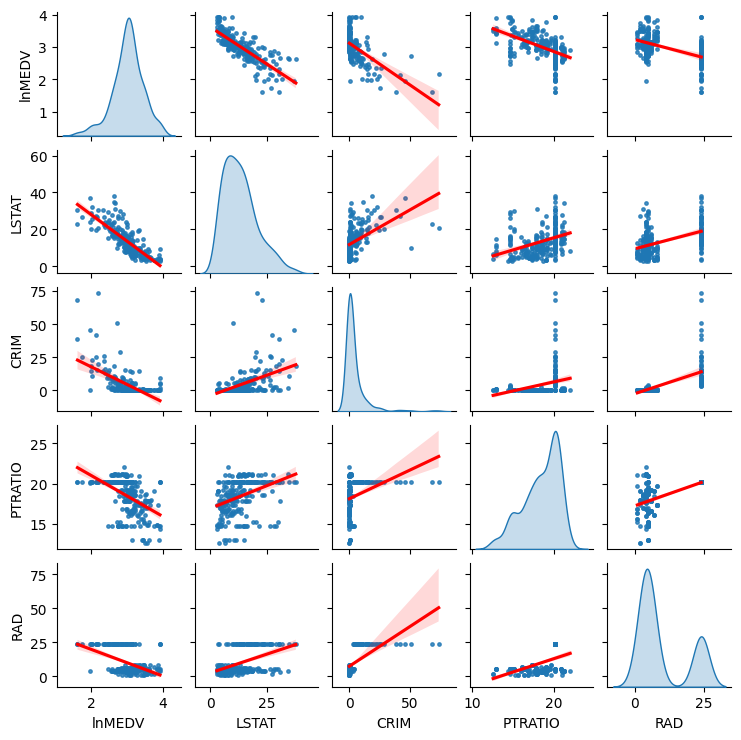

In [146]:
# Data explore
X = ['LSTAT', 'CRIM', 'PTRATIO', 'RAD']
g = sns.pairplot(training_set[['lnMEDV']+X], kind="reg", corner=False, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s':6}}, diag_kind='kde', height=1.5)

最后是用best model对整个dataset进行回归分析，结果如下

In [52]:
syntax_var=str(X).replace("[","").replace("]","").replace("'","").replace(","," +")
#model = sm.OLS(y, X).fit()
reg_model = ols('lnMEDV ~ '+ syntax_var, data=df).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     323.6
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          2.58e-137
Time:                        15:16:13   Log-Likelihood:                 58.101
No. Observations:                 506   AIC:                            -106.2
Df Residuals:                     501   BIC:                            -85.07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3170      0.089     48.735      0.0

In [53]:
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

In [54]:
wls_whole_model = wls('lnMEDV ~ '+ syntax_var, data=df, weights = 1/residual_model.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.718
Model:                            WLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     319.2
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          3.02e-136
Time:                        15:16:17   Log-Likelihood:                 64.059
No. Observations:                 506   AIC:                            -118.1
Df Residuals:                     501   BIC:                            -96.99
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3397      0.085     51.004      0.0

<b>Identifying Influential Cases—Hat Matrix Leverage Values, DFFITS, Cook’s Distance, and DFBETAS Measures</b>

In [85]:
from scipy.stats import f
wls_whole_model_beforefit = wls('lnMEDV ~ '+ syntax_var, data=df, weights = 1/residual_model.fittedvalues)

wls_x = pd.DataFrame(wls_whole_model_beforefit.wexog, columns=['Intercept']+X)

res = sm.OLS(wls_whole_model_beforefit.wendog, wls_x).fit()
infl = res.get_influence()
sm_fr = infl.summary_frame()

In [70]:
sm_fr

,dfb_Intercept,dfb_LSTAT,dfb_CRIM,dfb_PTRATIO,dfb_RAD,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.089,0.036,-0.026,0.065,0.024,0.003,-1.483,0.008,-0.130,-1.485,-0.130
1,-0.001,0.002,-0.005,-0.005,0.021,0.000,-0.622,0.004,-0.038,-0.621,-0.038
2,0.000,-0.033,0.013,0.013,-0.019,0.001,0.711,0.006,0.055,0.711,0.055
3,-0.009,-0.030,0.008,0.019,-0.012,0.000,0.483,0.008,0.043,0.483,0.043
4,-0.025,-0.055,0.017,0.046,-0.037,0.002,1.331,0.006,0.100,1.332,0.100
...,...,...,...,...,...,...,...,...,...,...,...
501,-0.025,-0.005,0.005,0.029,-0.023,0.000,0.347,0.011,0.037,0.347,0.037
502,0.011,0.003,-0.003,-0.013,0.010,0.000,-0.156,0.011,-0.017,-0.156,-0.017
503,0.007,0.004,-0.002,-0.009,0.006,0.000,-0.096,0.013,-0.011,-0.096,-0.011
504,0.025,0.013,-0.007,-0.030,0.020,0.000,-0.331,0.013,-0.038,-0.331,-0.038


In [189]:
# 1. Hat Matrix Leverage Values
# X has 5% outlier
hat_diag = sm_fr['hat_diag'].sort_values()>2*sm_fr['hat_diag'].mean()
idx_hat = hat_diag[hat_diag==True].index
(hat_diag).mean()

0.04940711462450593

In [190]:
sm_fr['dffits']

0     -0.130
1     -0.038
2      0.055
3      0.043
4      0.100
       ...  
501    0.037
502   -0.017
503   -0.011
504   -0.038
505   -0.328
Name: dffits, Length: 506, dtype: float64

In [191]:
# 2. DFFITS
# X has 7% outlier
dffits = abs(sm_fr['dffits']).sort_values() > np.sqrt((len(X)+1)/len(df))*2
idx_dffits = dffits[dffits==True].index
(dffits).mean()

0.06521739130434782

In [192]:
# 3. Cook’s Distance
# X has 0% outlier
cooks_d = sm_fr['cooks_d'].sort_values()
fcdf = f.cdf(cooks_d, len(X)+1, len(df) - (len(X)+1))
fcdf = pd.Series(fcdf , index = cooks_d.index)
fcdf

235   0.000
252   0.000
85    0.000
249   0.000
78    0.000
       ... 
374   0.001
412   0.001
214   0.001
405   0.004
380   0.037
Length: 506, dtype: float64

In [193]:
# 4. DFBETAS
# For LSTAT, X has 8% outlier
dfbetas_LSTAT = abs(sm_fr['dfb_LSTAT']).sort_values() > 2/np.sqrt(len(sm_fr['dfb_LSTAT']))
idx_dfbetas_LSTAT = dfbetas_LSTAT[dfbetas_LSTAT==True].index
(dfbetas_LSTAT).mean()

0.07707509881422925

In [194]:
# 4. DFBETAS
# For CRIM, X has 2% outlier
dfbetas_CRIM = abs(sm_fr['dfb_CRIM']).sort_values() > 2/np.sqrt(len(sm_fr['dfb_CRIM']))
idx_dfbetas_CRIM = dfbetas_CRIM[dfbetas_CRIM==True].index
(dfbetas_CRIM).mean()

0.019762845849802372

In [195]:
# 4. DFBETAS
# For PTRATIO, X has 6% outlier
dfbetas_PTRATIO = abs(sm_fr['dfb_PTRATIO']).sort_values() > 2/np.sqrt(len(sm_fr['dfb_PTRATIO']))
idx_dfbetas_PTRATIO = dfbetas_PTRATIO[dfbetas_PTRATIO==True].index
(dfbetas_PTRATIO).mean()

0.05928853754940711

In [196]:
# 4. DFBETAS
# For RAD, X has 6% outlier
dfbetas_RAD = abs(sm_fr['dfb_RAD']).sort_values() > 2/np.sqrt(len(sm_fr['dfb_RAD']))
idx_dfbetas_RAD = dfbetas_RAD[dfbetas_RAD==True].index
(dfbetas_RAD).mean()

0.05533596837944664

In [211]:
# unite different outlier idx from different betas
idx_dfbetas = idx_dfbetas_LSTAT.union(idx_dfbetas_CRIM).union(idx_dfbetas_PTRATIO).union(idx_dfbetas_RAD)
len(idx_dfbetas)/len(df)

0.15810276679841898

In [222]:
# using intersection to decide real outliers index from 4 measurements
# 3% outliers
idx_outlier = idx_hat.intersection(idx_dffits).intersection(idx_dfbetas)
len(idx_outlier)/len(df)

0.029644268774703556

In [223]:
idx_outlier

Index([214, 369, 374, 370, 368, 48, 148, 8, 141, 398, 427, 414, 405, 418, 380], dtype='int64')

In [224]:
# delete outliers and run regression again
df_no_outlier = df.drop(idx_outlier).reset_index(drop = True)

X = ['LSTAT', 'CRIM', 'PTRATIO', 'RAD']
syntax_var=str(X).replace("[","").replace("]","").replace("'","").replace(","," +")
#model = sm.OLS(y, X).fit()
reg_model = ols('lnMEDV ~ '+ syntax_var, data=df_no_outlier).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     326.3
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          3.85e-136
Time:                        17:42:10   Log-Likelihood:                 86.137
No. Observations:                 491   AIC:                            -162.3
Df Residuals:                     486   BIC:                            -141.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3189      0.084     51.321      0.0

In [225]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(reg_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(reg_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]

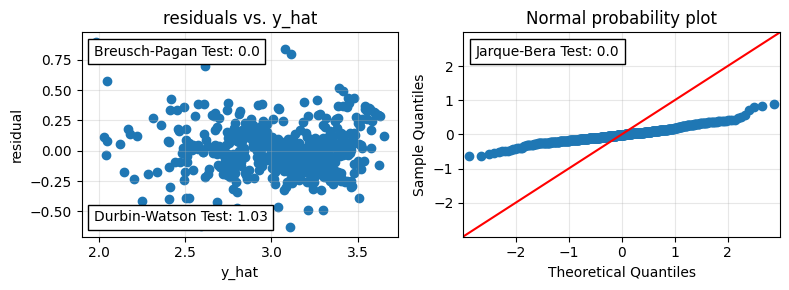

In [226]:
from matplotlib.offsetbox import AnchoredText
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues, reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)
anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(dwt,2)), loc=3)
axs[0].add_artist(anchored_text)

sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

In [227]:
# final wls regression result
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

wls_whole_model = wls('lnMEDV ~ '+ syntax_var, data=df_no_outlier, weights = 1/residual_model.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.727
Model:                            WLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     323.6
Date:                Thu, 02 Nov 2023   Prob (F-statistic):          1.69e-135
Time:                        17:42:18   Log-Likelihood:                 88.727
No. Observations:                 491   AIC:                            -167.5
Df Residuals:                     486   BIC:                            -146.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3319      0.082     52.529      0.0

In [228]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(wls_whole_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(wls_whole_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(wls_whole_model.resid, wls_whole_model.model.exog)[1]

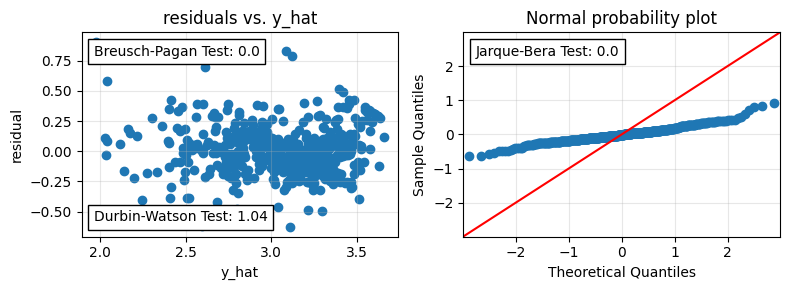

In [229]:
from matplotlib.offsetbox import AnchoredText
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(wls_whole_model.fittedvalues, wls_whole_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)
anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(dwt,2)), loc=3)
axs[0].add_artist(anchored_text)

sm.qqplot(wls_whole_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

In [230]:
# using new regression model to test dataset with outliers
SSR = ((wls_whole_model.predict(df[X]) - df['lnMEDV'].mean())**2).sum()
SST = ((df['lnMEDV'] - df['lnMEDV'].mean())**2).sum()

In [231]:
# R square
# get better result
SSR/SST

0.7908705383404848